# Titanic Survival Prediction
## Introduction
This kernel aims to prepare the Titanic dataset for machine learning models by handling missing data using a K-fold cross-validation approach, performing feature engineering, encoding categorical features, and training a model to predict survival.

## 1. Import Libraries

First, we import all necessary libraries for data manipulation, machine learning, data visualization, and preprocessing.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import warnings

#for Age forecast
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor

# Suppress warnings
warnings.filterwarnings('ignore')


# Set plot style for seaborn
sns.set(style="whitegrid")

print('Packages were loaded')


Packages were loaded


## 2. Load Data

Load the training and test datasets to begin our analysis.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    object 
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count 

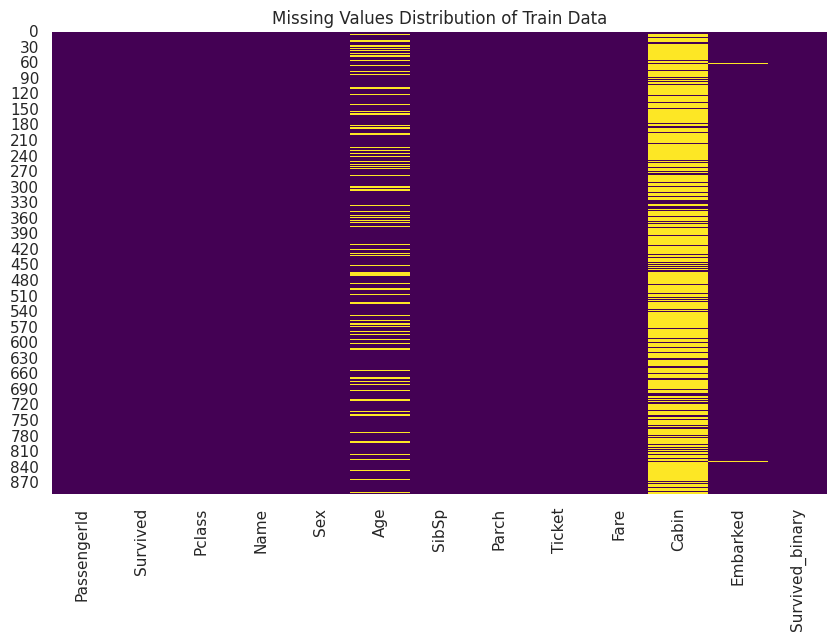

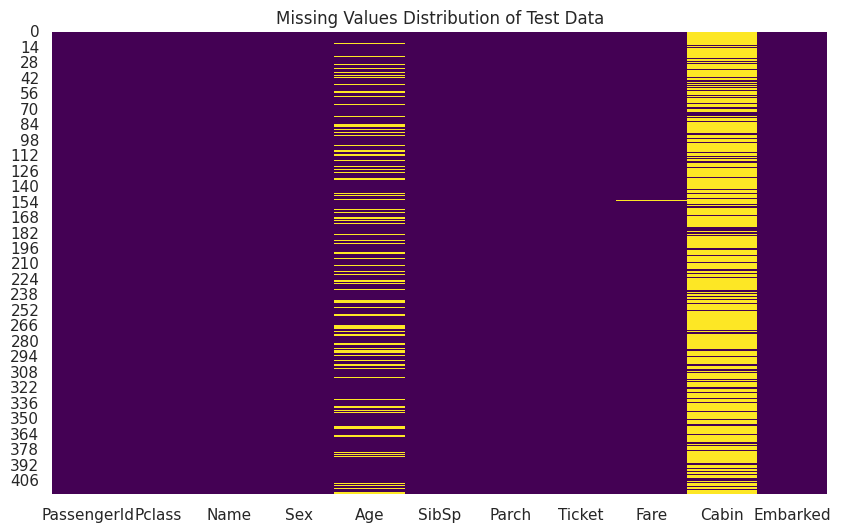

In [44]:
train = pd.read_csv('/kaggle/input/2024-sce-ml-course/train_2022.csv')
test = pd.read_csv('/kaggle/input/2024-sce-ml-course/test_2022.csv')

print(train.info())
print("-"*100)
print(test.info())




## 3. Visualizing Data Characteristics
We visualize the data to understand its structure, identify missing values, and observe feature distributions and correlations.
#### Graphs are ploted by q:
1. Missing Values Distribution
1. Histograms of Numerical Features
1. Feature Correlation Matrix
1. Summary Statistics of Numerical Features
1. Categorical Feature Distribution

In [ ]:

train["Survived_binary"]=train["Survived"].map({'T':1,'F': 0})
def visualize_data_analysis(df, df_name, q=[1, 2, 3]):
    df_temp = df.copy()
    
    if 1 in q:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df_temp.isnull(), cbar=False, cmap='viridis')
        plt.title(f'Missing Values Distribution of {df_name}')
        plt.show()

    if 2 in q:
        numeric_df = df_temp.select_dtypes(include=[np.number])
        if not numeric_df.empty:
            numeric_df.hist(bins=20, figsize=(20, 15), edgecolor='black')
            plt.suptitle(f'Histograms of Numerical Features of {df_name}')
            plt.show()

    if 3 in q:
        numeric_df = df_temp.select_dtypes(include=[np.number])
        plt.figure(figsize=(15, 10))
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title(f'Feature Correlation Matrix of {df_name}')
        plt.show()
    # Visualize training data characteristics
visualize_data_analysis(train, "Train Data", q=[1])
visualize_data_analysis(test, "Test Data", q=[1])

## 4. Feature Engineering, Encoding and handling missing data
* Perform feature engineering.
    * Title: Extract titles from names and categorize them into common and rare titles.
    * Married: Create a binary feature indicating if a passenger is married.
    * FamilySize: Calculate family size by summing the number of siblings/spouses and parents/children and adding 1 (for the passenger themselves).
    * IsAlone: Create a binary feature indicating if a passenger is alone.
    * FarePerPerson: Calculate the fare per person by dividing the fare by the family size.
    * TicketPrefix: Extract the prefix of the ticket.
    * IsChild: Create a binary feature indicating if a passenger is a child.
    * Title_Category: Map titles into broader categories and encode them numerically.


* Encode categorical features.
    * Encode 'Sex' as binary feature.
    * Encode 'Embarked','Deck', 'TicketPrefix', and 'TicketNumber' as numerical labels.
    

* Handle missing data  
    1. Fill missing 'FarePerPerson' with the mean of the Deck it relates to.
    1. Fill missing 'Cabin' values with 'Unknown'.
    1. Fill missing 'Embarked' with the mode.


In [45]:
import pandas as pd

def extract_ticket_features(ticket):
    ticket = ticket.replace('.', '').replace('/', '').split()
    ticket_prefix = ticket[0] if not ticket[0].isdigit() else 'NoPrefix'
    ticket_number = ticket[-1] if ticket[-1].isdigit() else 'NoNumber'
    return ticket_prefix, ticket_number

def feature_engineering_encoding_missingData(df):
    df_temp = df.copy()
    
    # Fill missing 'Embarked' with the most frequent value
    df_temp['Embarked'].fillna(df_temp['Embarked'].mode()[0], inplace=True)
    
    # Fill missing 'Cabin' with 'Unknown'
    df_temp['Cabin'].fillna('Unknown', inplace=True)
    
    df_temp['Cabin_Binary'] = df_temp['Cabin'].apply(lambda x: 0 if x == 'Unknown' else 1)
    
    
    # Create deck feature extracted from the cabin number
    df_temp['Deck'] = df_temp['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'Unknown')
    df_temp['Deck'] = df_temp['Deck'].replace('Unknown', np.nan)
    
    # Create new features
    # Extract titles from names
    df_temp['Title'] = df_temp['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    
    # Replace rare titles with 'Rare'
    df_temp['Title'] = df_temp['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df_temp['Title'] = df_temp['Title'].replace('Mlle', 'Miss')
    df_temp['Title'] = df_temp['Title'].replace('Ms', 'Miss')
    df_temp['Title'] = df_temp['Title'].replace('Mme', 'Mrs')
    
    # Create 'Married' feature based on 'Mrs' title
    df_temp['Married'] = df_temp['Title'].apply(lambda x: 1 if x == 'Mrs' else 0)
    
    # Combine rare titles into a single category 'Rare'
    df_temp['Title'] = df_temp['Title'].apply(lambda x: 'Rare' if x not in ['Mr', 'Mrs', 'Miss', 'Master'] else x)
    
    # Create family size feature
    df_temp['FamilySize'] = df_temp['SibSp'] + df_temp['Parch'] + 1
    
    # Create 'IsAlone' feature
    df_temp['IsAlone'] = df_temp['FamilySize'].apply(lambda x: 1 if x == 1 else 0)
    
    # Create 'FarePerPerson' feature
    df_temp['FarePerPerson'] = df_temp['Fare'] / df_temp['FamilySize']
    df_temp = df_temp.drop(columns=['Fare'])
    
    # Fill missing 'FarePerPerson' with the median value of the Deck it relates to
    fare_medians = df_temp.groupby('Deck')['FarePerPerson'].median()
    df_temp.loc[df_temp['FarePerPerson'].isnull(), 'FarePerPerson'] = df_temp.loc[df_temp['FarePerPerson'].isnull(), 'Deck'].map(fare_medians)
    
    # Extract ticket prefix and number
    df_temp['TicketPrefix'], df_temp['TicketNumber'] = zip(*df_temp['Ticket'].apply(extract_ticket_features))
    
    # Group titles into broader categories
    title_mapping = {'Mr': 'Common', 'Mrs': 'Common', 'Miss': 'Common', 'Master': 'Common', 'Rare': 'Royalty'}
    df_temp['Title_Category'] = df_temp['Title'].map(title_mapping)
    
    # Convert 'Survived' from 'T'/'F' to 1/0 for binary classification tasks
    if 'Survived' in df_temp.columns:
        df_temp['Survived_binary'] = df_temp['Survived'].map({'T': 1, 'F': 0})
    
    # Encode 'Sex' as binary feature
    df_temp['Sex'] = df_temp['Sex'].map({'male': 0, 'female': 1})
    
    
    # Check if a passenger is part of a group based on ticket number
    df_temp['GroupSize'] = df_temp.groupby('Ticket')['Ticket'].transform('count')
    df_temp['IsInGroup'] = df_temp['GroupSize'].apply(lambda x: 1 if x > 1 else 0)
    df_temp = df_temp.drop(columns=['GroupSize'])
    
    # One-hot encode categorical features separately
    one_hot_encoded = pd.get_dummies(df_temp[['Sex', 'IsAlone', 'Cabin_Binary', 'Married']], drop_first=True)
    
    # Ensure the one-hot encoded columns are numeric
    one_hot_encoded = one_hot_encoded.astype(int)
    
    # Drop the original categorical columns from df_temp
    df_temp = df_temp.drop(columns=['Sex', 'IsAlone', 'Cabin_Binary', 'Married'])
    
    # Concatenate the one-hot encoded columns back to df_temp
    df_temp = pd.concat([df_temp, one_hot_encoded], axis=1)
    
      # Label encode categorical features
    le = LabelEncoder()
    categorical_cols = ['Embarked', 'Deck', 'Title', 'TicketPrefix', 'TicketNumber', 'Title_Category']
    for col in categorical_cols:
        df_temp[col] = le.fit_transform(df_temp[col].astype(str))
    
    
    return df_temp

train_encoded = feature_engineering_encoding_missingData(train)
test_encoded = feature_engineering_encoding_missingData(test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Survived         891 non-null    object 
 2   Pclass           891 non-null    int64  
 3   Name             891 non-null    object 
 4   Age              714 non-null    float64
 5   SibSp            891 non-null    int64  
 6   Parch            891 non-null    int64  
 7   Ticket           891 non-null    object 
 8   Cabin            891 non-null    object 
 9   Embarked         891 non-null    int64  
 10  Survived_binary  891 non-null    int64  
 11  Deck             891 non-null    int64  
 12  Title            891 non-null    int64  
 13  FamilySize       891 non-null    int64  
 14  FarePerPerson    891 non-null    float64
 15  TicketPrefix     891 non-null    int64  
 16  TicketNumber     891 non-null    int64  
 17  Title_Category  

## 5. Regression for Filling 'Age' Missing Values
Separate rows with missing and non-missing ages for training data and prepare training data.

### Steps:
1. Separate rows with missing and non-missing ages.
1. Select the best features using Mutual Information (MI).
1. Train models to predict missing ages.
1. Predict missing ages for training and test data.

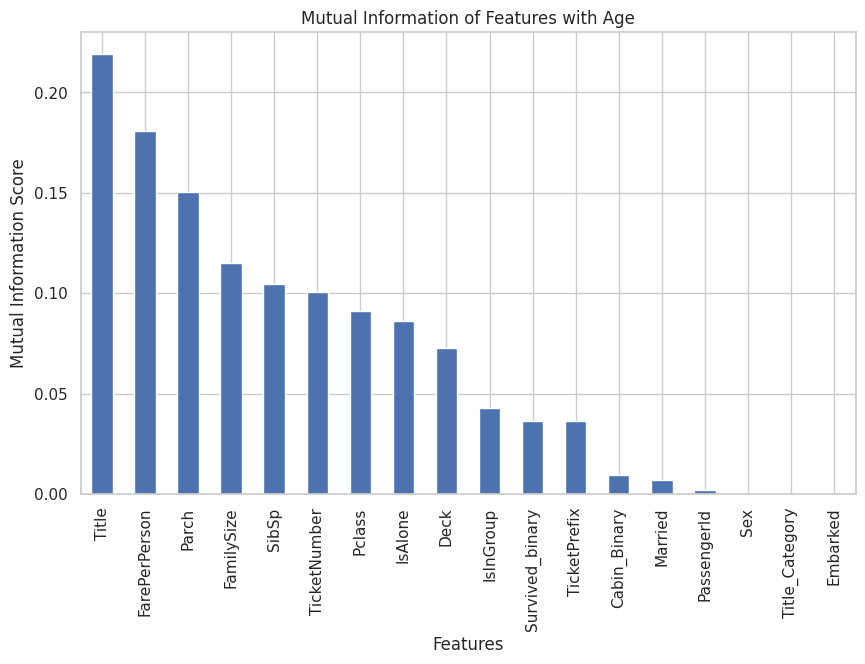

Best parameters for Decision Tree: {'max_depth': 10}
Best score for Decision Tree: -209.11333944931434
Best parameters for K-Nearest Neighbors: {'n_neighbors': 9}
Best score for K-Nearest Neighbors: -186.79030254654407
<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 888
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Survived         891 non-null    object 
 2   Pclass           891 non-null    int64  
 3   Name             891 non-null    object 
 4   Age              891 non-null    float64
 5   SibSp            891 non-null    int64  
 6   Parch            891 non-null    int64  
 7   Ticket           891 non-null    object 
 8   Cabin            891 non-null    object 
 9   Embarked         891 non-null    int64  
 10  Survived_binary  891 non-null    int64  
 11  Deck             891 non-null    int64  
 12  Title            891 non-null   

In [46]:
def separate_missing_ages(df):
    df_missing_age = df[df['Age'].isnull()]
    df_non_missing_age = df[df['Age'].notnull()]
    return df_missing_age, df_non_missing_age

def select_features(X, y, num_features, plot=True):
    # Ensure all features are numeric
    X_numeric = X.select_dtypes(include=[np.number])
    
    mi = mutual_info_regression(X_numeric, y)
    mi_series = pd.Series(mi, index=X_numeric.columns)
    selected_features = mi_series.sort_values(ascending=False).head(num_features).index.tolist()

    if plot:
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        mi_series.sort_values(ascending=False).plot(kind='bar')
        plt.title('Mutual Information of Features with Age')
        plt.xlabel('Features')
        plt.ylabel('Mutual Information Score')
        plt.show()

    return selected_features

def train_age_predictors(X, y):
    param_grid = {
        'Decision Tree': {'max_depth': [None, 10, 20, 30]},
        'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9, 11]}
    }
    
    models = {
        'Decision Tree': DecisionTreeRegressor(),
        'K-Nearest Neighbors': KNeighborsRegressor()
    }
    
    best_models = {}
    for name in models:
        grid_search = GridSearchCV(models[name], param_grid[name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best score for {name}: {grid_search.best_score_}")
    
    # Define the Voting Regressor
    voting_regressor = VotingRegressor(estimators=[
        ('dt', best_models['Decision Tree']),
        ('knn', best_models['K-Nearest Neighbors'])
    ])
    voting_regressor.fit(X, y)

    return best_models, voting_regressor

def predict_missing_ages(voting_regressor, df_missing_age, features):
    X_missing = df_missing_age[features]
    
    # Ensure the feature names match the training data
    X_missing = X_missing[voting_regressor.feature_names_in_]

    # Predicting age for the missing rows
    df_missing_age['Age'] = voting_regressor.predict(X_missing)
    
    return df_missing_age

# Separate rows with missing and non-missing ages for training data
df_missing_age_train, df_non_missing_age_train = separate_missing_ages(train_encoded)
df_missing_age_test, df_non_missing_age_test = separate_missing_ages(test_encoded)

# Prepare training data
X_train = df_non_missing_age_train.drop(columns=['Age'])
y_train = df_non_missing_age_train['Age']

# Select best features using MI
selected_features = select_features(X_train, y_train, num_features=7)
X_train_selected = X_train[selected_features]

# Train the models
best_models, voting_regressor = train_age_predictors(X_train_selected, y_train)

# Ensure the selected features are present in both train and test datasets
common_features = list(set(selected_features) & set(df_missing_age_test.columns))

# Predict missing ages for training and test data
df_missing_age_train = predict_missing_ages(voting_regressor, df_missing_age_train, common_features)
df_missing_age_test = predict_missing_ages(voting_regressor, df_missing_age_test, common_features)

# Combine the non-missing and newly predicted ages for training and test data
train_encoded = pd.concat([df_non_missing_age_train, df_missing_age_train])
test_encoded = pd.concat([df_non_missing_age_test, df_missing_age_test])



### 4.1 Age Related Feature Engineering
Create additional features related to age.
1. AgeGroup: Bin the ages into categories.
1. IsChild: Create a binary feature indicating if a passenger is a child.

In [47]:
def age_related(train,test):  

    combine=[train,test]
    for df_temp in combine:
        
        age_bins = [0, 12, 18, 25, 35, 60, np.inf]
        age_labels = [1, 2, 3, 4, 5, 6]
        df_temp['AgeGroup'] = pd.cut(df_temp['Age'], bins=age_bins, labels=age_labels).astype(int)
    
      
        # Apply the bins to create the AgeGroup feature
        df_temp['AgeGroupNum'] = pd.cut(df_temp['Age'], bins=age_bins, labels=age_labels)
      
        age_labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']
       
        # Apply the bins to create the AgeGroup feature
        df_temp['AgeGroup'] = pd.cut(df_temp['Age'], bins=age_bins, labels=age_labels)


        # Create 'IsChild' feature
        df_temp['IsChild'] = df_temp['Age'].apply(lambda x: 1 if x < 18 else 0)
        df_temp.info()
        
age_related(train_encoded,test_encoded)
    

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 888
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      891 non-null    int64   
 1   Survived         891 non-null    object  
 2   Pclass           891 non-null    int64   
 3   Name             891 non-null    object  
 4   Age              891 non-null    float64 
 5   SibSp            891 non-null    int64   
 6   Parch            891 non-null    int64   
 7   Ticket           891 non-null    object  
 8   Cabin            891 non-null    object  
 9   Embarked         891 non-null    int64   
 10  Survived_binary  891 non-null    int64   
 11  Deck             891 non-null    int64   
 12  Title            891 non-null    int64   
 13  FamilySize       891 non-null    int64   
 14  FarePerPerson    891 non-null    float64 
 15  TicketPrefix     891 non-null    int64   
 16  TicketNumber     891 non-null    int64   
 17  Ti

## 5. Exploratory Data Analysis

Conduct a thorough exploratory data analysis to visualize and understand the dataset better.

### Simple Binary Encoding for 'Survived'
Convert 'Survived' from 'Y'/'N' to 1/0 for easier processing in machine learning models.




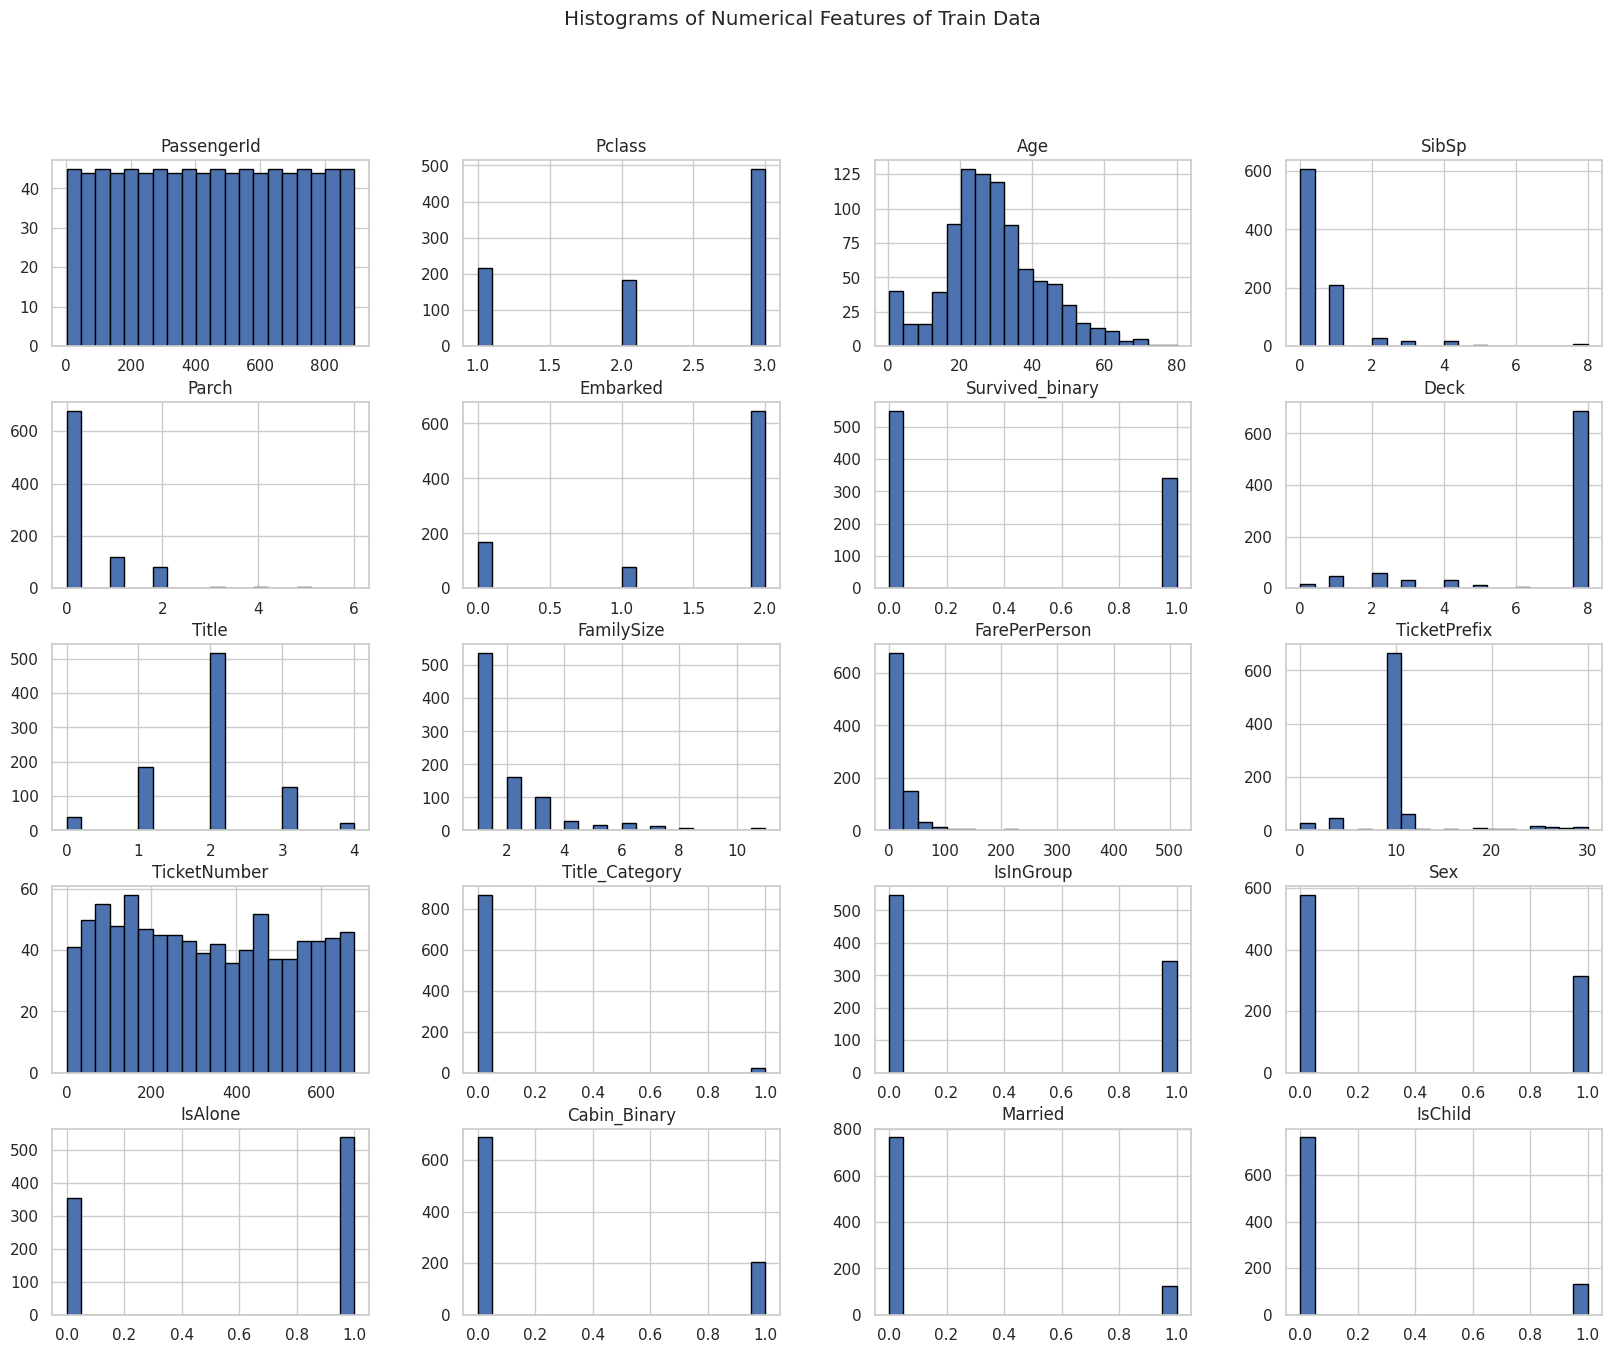

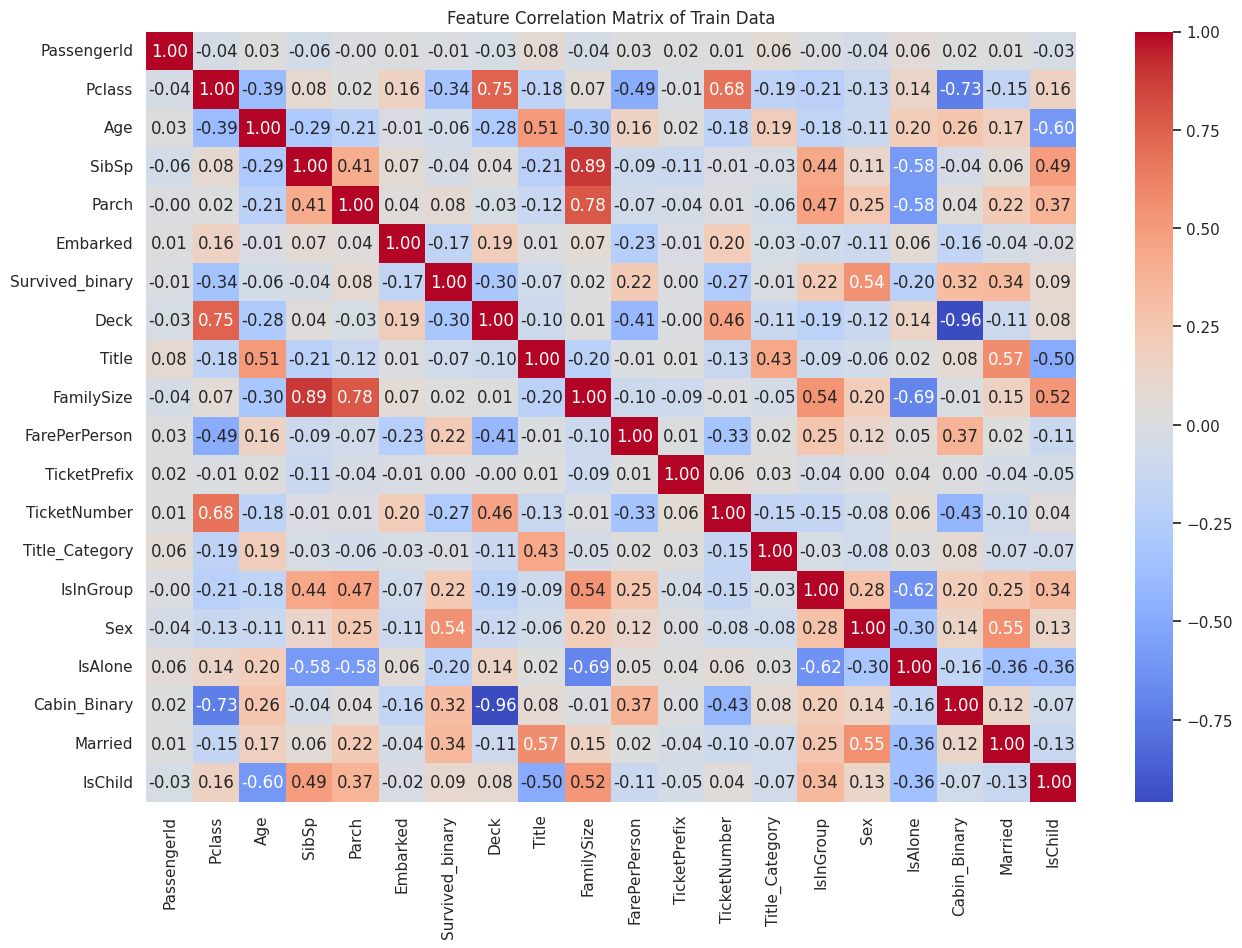

In [48]:
train["Survived_binary"]=train["Survived"].map({'T':1,'F': 0})
def visualize_data_analysis(df, df_name, q=[1, 2, 3]):
    df_temp = df.copy()
    
    if 1 in q:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df_temp.isnull(), cbar=False, cmap='viridis')
        plt.title(f'Missing Values Distribution of {df_name}')
        plt.show()

    if 2 in q:
        numeric_df = df_temp.select_dtypes(include=[np.number])
        if not numeric_df.empty:
            numeric_df.hist(bins=20, figsize=(20, 15), edgecolor='black')
            plt.suptitle(f'Histograms of Numerical Features of {df_name}')
            plt.show()

    if 3 in q:
        numeric_df = df_temp.select_dtypes(include=[np.number])
        plt.figure(figsize=(15, 10))
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title(f'Feature Correlation Matrix of {df_name}')
        plt.show()

# Visualize training data characteristics
visualize_data_analysis(train_encoded, "Train Data",[2,3])


# 6. Prepare Data for Modeling
Extract all numerical features and the target variable from the training data.

In [49]:
# Extract all numerical columns
numerical_cols = train_encoded.select_dtypes(include=[np.number]).columns.tolist()
X = train_encoded[numerical_cols].drop(columns=['Survived_binary'])
y = train_encoded['Survived_binary']

print('X and y were loaded')


X and y were loaded


# 7. Define Models
We will define our models: Decision Tree, K-Nearest Neighbors, Gaussian Naive Bayes, and a Voting Classifier combining the three.

In [50]:



def define_models():
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Gaussian Naive Bayes': GaussianNB()
    }

    # Define the Voting Classifier
    voting_clf = VotingClassifier(estimators=[
        ('dt', models['Decision Tree']),
        ('knn', models['K-Nearest Neighbors']),
        ('gnb', models['Gaussian Naive Bayes'])
    ], voting='hard')
    models['Voting Classifier'] = voting_clf

    return models

def hyperparameter_tuning(models, X, y):
    param_grid = {
        'Decision Tree': {
            # Criteria to measure the quality of a split.
            # 'gini' for Gini impurity and 'entropy' for information gain.
            'criterion': ['gini', 'entropy'],
            # Strategy used to choose the split at each node.
            # 'best' to choose the best split, 'random' to choose the best random split.
            'splitter': ['best', 'random'],
            # Maximum depth of the tree. If None, nodes are expanded until all leaves are pure or contain less than min_samples_split samples.
            'max_depth': [None, 10, 20, 30, 40, 50],
            # Minimum number of samples required to split an internal node.
            'min_samples_split': [2, 5, 10],
            # Minimum number of samples required to be at a leaf node.
            'min_samples_leaf': [1, 2, 4],
            # Complexity parameter used for Minimal Cost-Complexity Pruning. The larger the alpha, the more the tree is pruned.
            'ccp_alpha': [0.0, 0.01, 0.02]
        },
        'K-Nearest Neighbors': {
            # Number of neighbors to use.
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            # Weight function used in prediction.
            # 'uniform' means all points in each neighborhood are weighted equally.
            # 'distance' means closer neighbors have more influence.
            'weights': ['uniform', 'distance'],
            # Algorithm used to compute the nearest neighbors.
            # 'auto' tries to decide the most appropriate algorithm based on the values passed to fit method.
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            # Power parameter for the Minkowski metric.
            # 1 for Manhattan distance, 2 for Euclidean distance.
            'p': [1, 2],
            # Leaf size Affects the speed of the construction and query.
            'leaf_size': [10, 20, 30, 40, 50]
        },
        'Gaussian Naive Bayes': {
            # Portion of the largest variance of all features that is added to variances for stability.
            'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03]
        }
    }

    best_models = {}
    for name in models:
        if name=='Voting Classifier':
            continue
        grid_search = GridSearchCV(models[name], param_grid[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X, y)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best score for {name}: {grid_search.best_score_}")

    # Updating the Voting Classifier with the best models
    voting_clf = VotingClassifier(estimators=[
        ('dt', best_models['Decision Tree']),
        ('knn', best_models['K-Nearest Neighbors']),
        ('gnb', best_models['Gaussian Naive Bayes'])
    ], voting='hard')
    best_models['Voting Classifier'] = voting_clf

    return best_models

models = define_models()
best_models = hyperparameter_tuning(models, X, y)




Best parameters for Decision Tree: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Best score for Decision Tree: 0.823821480133074
Best parameters for K-Nearest Neighbors: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
Best score for K-Nearest Neighbors: 0.6341347059192769
Best parameters for Gaussian Naive Bayes: {'var_smoothing': 1e-09}
Best score for Gaussian Naive Bayes: 0.7654949469587596


# 8. Feature Selection Using Mutual Information
Use mutual information to select the most relevant features.

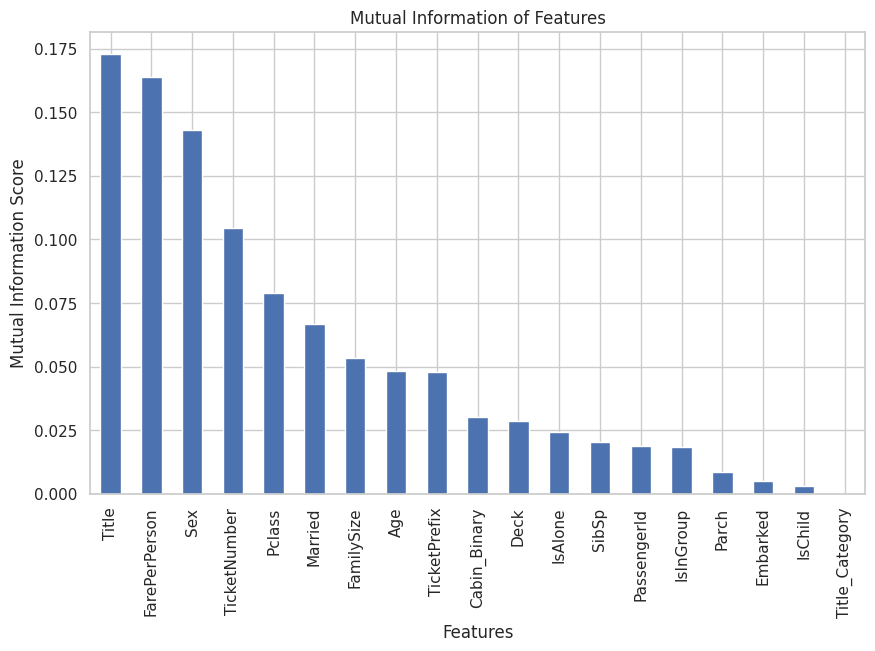

Selected features: ['Title', 'FarePerPerson', 'Sex', 'TicketNumber', 'Pclass', 'Married', 'FamilySize', 'Age', 'TicketPrefix', 'Cabin_Binary']


In [51]:
def select_features(X, y, num_features, plot=True):
    mi = mutual_info_classif(X, y)
    mi_series = pd.Series(mi, index=X.columns)
    selected_features = mi_series.sort_values(ascending=False).head(num_features).index.tolist()

    if plot:
        plt.figure(figsize=(10, 6))
        mi_series.sort_values(ascending=False).plot(kind='bar')
        plt.title('Mutual Information of Features')
        plt.xlabel('Features')
        plt.ylabel('Mutual Information Score')
        plt.show()

    return selected_features



selected_features = select_features(X, y, num_features=10)
print(f"Selected features: {selected_features}")


# 9. Evaluate Individual Models Using K-Fold Cross-Validation
Evaluate each individual model using K-fold cross-validation.

In [52]:
# Evaluate models
def evaluate_models(models, X, y, k, verbose=False):
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=k, scoring='accuracy')
        results[name] = (scores.mean(), scores.std())
        if verbose:
            print(f"Model: {name}, Mean Accuracy: {scores.mean():.4f}, Std: {scores.std():.4f}")
    return results


print('defs been loaded')

defs been loaded


## 10. Find Best K and Best Amount of Features
Iterate over multiple K-fold configurations and multiple MI thresholds to find the best combination.

In [53]:
def find_best_kfold_mi(models, X, y, k_values, mi_values):
    best_score = 0
    best_score_std = float('inf')
    best_k = 0
    best_mi = 0
    best_model = ''
    best_results = {}

    for k in k_values:
        for mi in mi_values:
            selected_features = select_features(X, y, mi, False)
            X_selected = X[selected_features]

            results = evaluate_models(models, X_selected, y, k, False)
            for model_name, (mean_score, std_score) in results.items():
                if mean_score-std_score > best_score-best_score_std :
                    best_score = mean_score
                    best_score_std = std_score
                    best_k = k
                    best_mi = mi
                    best_model = model_name
                    best_results = {
                        'model': model_name,
                        'features': selected_features,
                        'score': mean_score,
                        'std': std_score
                    }
    return best_model, best_mi, best_k, best_results

# Example usage:
k_values = range(3, 13, 1)  # Different K values to try
mi_values = range(3, 13, 1)  # Different MI values to try
best_model, best_mi, best_k, best_results = find_best_kfold_mi(models, X, y, k_values, mi_values)

print(f"Best Model: {best_model}")
print(f"Best MI: {best_mi}")
print(f"Best K: {best_k}")
print(f"Score: {best_results['score']:.4f} ± {best_results['std']:.4f}")
print(f"Selected Features: {best_results['features']}")


Best Model: Voting Classifier
Best MI: 4
Best K: 3
Score: 0.7946 ± 0.0126
Selected Features: ['Title', 'Sex', 'FarePerPerson', 'TicketNumber']


# 11. Train the Best Model on the Entire Training Dataset
Train the best model on the entire training dataset.


In [54]:
# Train the best model on the entire training dataset
def train_best_model(models, X, y, selected_features, best_model_name):
    best_model = models[best_model_name]
    X_selected = X[selected_features]
    best_model.fit(X_selected, y)
    return best_model

# Example usage:
best_model = train_best_model(best_models, X, y, best_results['features'], best_model)
print("Best model trained")


Best model trained


## 12. Make Predictions on the Test Dataset
Make predictions using the trained model on the test dataset.

In [55]:
# Ensure the 'PassengerId' column is present in the test dataset
features = ['PassengerId'] + best_results['features']
X_test = test_encoded[features]

def make_predictions(model, X_test, selected_features, output_file):
    # Ensure PassengerId is not included in the features used for prediction
    X_test_selected = X_test[selected_features].drop(columns=['PassengerId'])
    predictions = model.predict(X_test_selected)
    
    result_df = pd.DataFrame({
        'PassengerId': X_test['PassengerId'],
        'Survived': predictions
    })
    
    result_df['Survived'] = result_df['Survived'].map({1: 'T', 0: 'F'})
    result_df.to_csv(output_file, index=False)
    
    return result_df

predictions_df = make_predictions(best_model, X_test, features, 'submission.csv')
print(predictions_df)


     PassengerId Survived
0            892        F
1            893        T
2            894        F
3            895        F
4            896        T
..           ...      ...
408         1300        T
410         1302        T
413         1305        F
416         1308        F
417         1309        T

[418 rows x 2 columns]


# 13. Plot the model performance¶
Plot the learning curve to check for overfitting or underfitting.



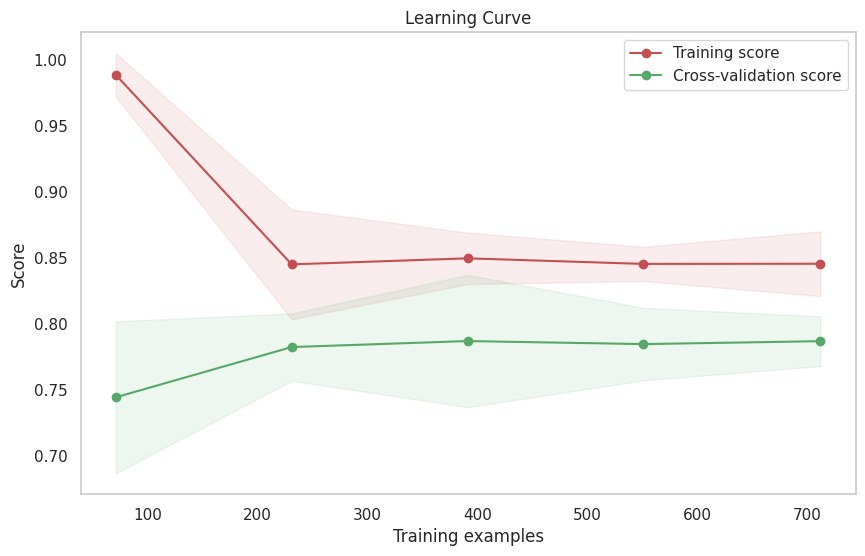

In [56]:

def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='accuracy')
    
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.title('Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Example usage for the best model
X_selected = X[best_results['features']]
plot_learning_curve(best_model, X_selected, y)
